<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from PIL import Image

In [2]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.RandomRotation(10),
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

100%|██████████| 170M/170M [00:11<00:00, 15.1MB/s]


In [4]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [5]:
# modelを作成
model = models.resnet50(pretrained=True)

# ① 最初の畳み込み層を変更（小さい画像用に適応）
#model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# ② MaxPooling を削除（小さい画像では不要）
#model.maxpool = nn.Identity()  # ダミーの層で置き換え

# 最後の層以外の勾配計算をしなくていいようにする
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():  # ResNetの最後の畳み込み層
    param.requires_grad = True

# 最後の層を付け替え
model.fc = nn.Linear(2048, 10)

model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 228MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        """
        Focal Lossの実装
        :param alpha: バランスパラメータ（クラスの不均衡を考慮）
        :param gamma: フォーカスパラメータ（誤分類されたサンプルに対する重み）
        :param reduction: 'mean'（平均損失）または 'sum'（合計損失）
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Focal Lossの計算
        :param inputs: モデルの出力（確率またはlogits）
        :param targets: 正解ラベル（one-hotでなく整数インデックス）
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # 確率 (1 - p_t)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
# 損失関数とoptimizerを設定
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingWarmRestartsの設定
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
## ラベルをone-hotに変換する関数
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes, device=labels.device)[labels]

# 平滑化の損失関数
def label_smoothed_nll_loss(lprobs, target, eps):
    nll_loss = -lprobs.gather(dim=-1, index=target.unsqueeze(-1))
    nll_loss = nll_loss.squeeze(-1)  # ラベルの次元を削除
    nll_loss = nll_loss.mean()

    smooth_loss = -lprobs.mean(dim=-1)
    smooth_loss = smooth_loss.mean()

    loss = (1.0 - eps) * nll_loss + eps * smooth_loss
    return loss

In [9]:
num_classes=10

In [10]:
patience = 15  # 何エポック連続で改善がないと学習を止めるか
best_val_loss = float('inf')  # 最小の検証損失
counter = 0  # 改善がなかった回数

# 学習のループ
num_epochs = 100
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # ラベルをone-hotエンコード
        one_hot_labels = one_hot_encode(labels, num_classes=10)

        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)

        # ソフトマックス後のlog確率を計算
        lprobs = torch.log_softmax(output, dim=-1)

        # 平滑化した損失を計算
        loss = label_smoothed_nll_loss(lprobs, labels, eps=0.1)

        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_lprobs = torch.log_softmax(val_output, dim=-1)
        val_loss = label_smoothed_nll_loss(val_lprobs, val_labels, eps=0.1)

        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    scheduler.step(val_running_loss)
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

    # Early Stopping の処理
    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # 最良モデルを保存
    else:
        counter += 1
        print(f"Early stopping patience count: {counter}/{patience}")

epoch: 0, loss: 0.9789840656827827, acc: 0.8111804127693176,      val loss: 0.9339463527971944, val acc: 0.8332667350769043
epoch: 1, loss: 0.8622673895598526, acc: 0.8624640107154846,      val loss: 0.8873630956338998, val acc: 0.8493410348892212
epoch: 2, loss: 0.8085389180360356, acc: 0.8807181715965271,      val loss: 0.852058983839358, val acc: 0.8617212176322937
epoch: 3, loss: 0.7864634643284388, acc: 0.8894753456115723,      val loss: 0.8237425018423281, val acc: 0.8717052340507507
epoch: 4, loss: 0.7695366480528966, acc: 0.8963331580162048,      val loss: 0.81452897010139, val acc: 0.8755990266799927
epoch: 5, loss: 0.7589344909308586, acc: 0.8996521234512329,      val loss: 0.8126765026832922, val acc: 0.8743010759353638
epoch: 6, loss: 0.7550748447844102, acc: 0.900351881980896,      val loss: 0.8321969665277499, val acc: 0.8652156591415405
Early stopping patience count: 1/15
epoch: 7, loss: 0.7464823069590754, acc: 0.9038307666778564,      val loss: 0.8137163708385188, val 

In [11]:
labels

tensor([8, 1, 0, 9, 3, 7, 4, 0, 3, 6, 1, 2, 7, 8, 8, 8], device='cuda:0')

In [12]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [13]:
prob = prob_pred[:, 0]

In [14]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([0.0117, 0.0114, 0.8386, 0.0124, 0.0137, 0.0121, 0.0100, 0.9102, 0.0094,
        0.0116, 0.0099, 0.0084, 0.0082, 0.0182, 0.0668, 0.0093],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [15]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

In [16]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0. 0. 0. 1.]
[0.  0.5 1.  1. ]
[       inf 0.9102077  0.8386032  0.00823868]


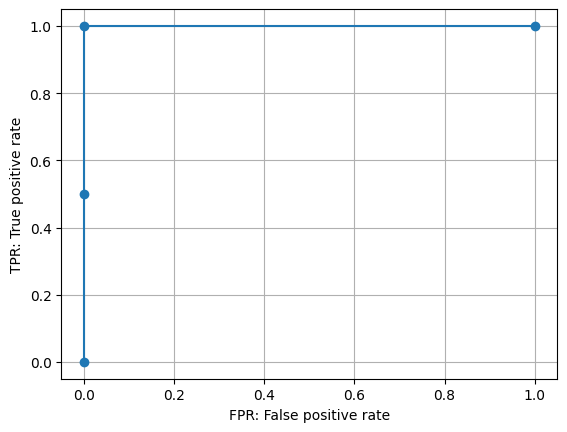

In [17]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [18]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.9747)
tensor(0.9062)
[[4899    9   14    9    6    3    8    2   28   22]
 [  13 4918    0    4    0    0    1    4   13   47]
 [  36    1 4837   29   29   27   26    7    7    1]
 [   7    1   34 4761   16  123   34   15    4    5]
 [   9    2   26   37 4859   30   11   24    2    0]
 [   2    0   14  141   30 4772    8   31    2    0]
 [   3    0   22   23   10   10 4923    0    8    1]
 [   9    1    6   16   24   23    3 4913    4    1]
 [  30    6    4    1    2    2    3    2 4936   14]
 [  13   52    5    5    0    1    1    1    7 4915]]
[[913  10  25   9   2   2   3   2  23  11]
 [  8 954   0   1   0   0   0   1   5  31]
 [ 16   1 877  26  25  20  20  10   4   1]
 [  4   6  20 805  22  89  16  23   8   7]
 [  2   0  21  23 895  12  12  34   1   0]
 [  5   2  13  82  16 859   3  14   2   4]
 [  3   3  11  20  23   5 927   2   6   0]
 [  8   0   9   5  12  19   1 942   2   2]
 [ 20  13   2   2   0   2   1   0 944  16]
 [  9  37   0   2   1   0   0   2   5 944]]
[0.9798 

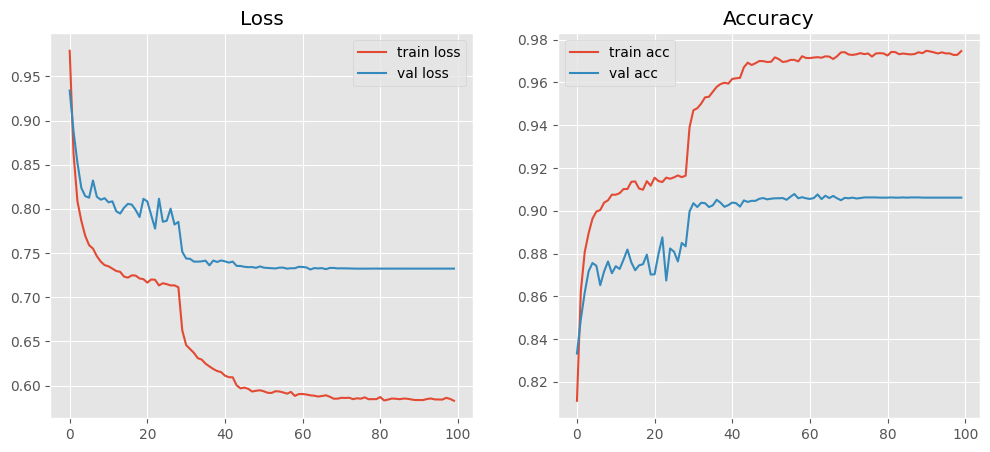

In [19]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [20]:
print(accs)
print(val_accs)

[tensor(0.8112), tensor(0.8625), tensor(0.8807), tensor(0.8895), tensor(0.8963), tensor(0.8997), tensor(0.9004), tensor(0.9038), tensor(0.9049), tensor(0.9075), tensor(0.9075), tensor(0.9082), tensor(0.9102), tensor(0.9102), tensor(0.9135), tensor(0.9137), tensor(0.9104), tensor(0.9098), tensor(0.9138), tensor(0.9117), tensor(0.9155), tensor(0.9139), tensor(0.9134), tensor(0.9155), tensor(0.9150), tensor(0.9156), tensor(0.9165), tensor(0.9157), tensor(0.9164), tensor(0.9390), tensor(0.9470), tensor(0.9479), tensor(0.9501), tensor(0.9530), tensor(0.9533), tensor(0.9557), tensor(0.9580), tensor(0.9593), tensor(0.9599), tensor(0.9595), tensor(0.9617), tensor(0.9620), tensor(0.9622), tensor(0.9671), tensor(0.9692), tensor(0.9682), tensor(0.9690), tensor(0.9700), tensor(0.9700), tensor(0.9695), tensor(0.9697), tensor(0.9717), tensor(0.9709), tensor(0.9696), tensor(0.9698), tensor(0.9705), tensor(0.9706), tensor(0.9698), tensor(0.9722), tensor(0.9714), tensor(0.9714), tensor(0.9716), tensor(

<ipython-input-30-df0e4e2c813e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_true = torch.tensor(y_val_true)


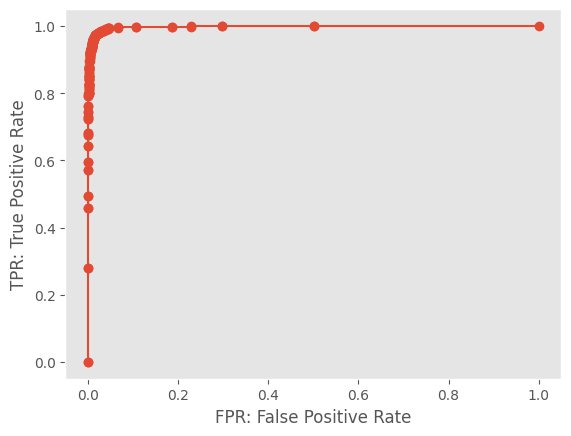

In [30]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# クラス0の確率を保存するリスト
probs = []

# モデルを推論モードにする
model.eval()

# メモリ節約のため、勾配計算を無効にする
with torch.no_grad():
    for val_imgs, _ in validation_dataloader:
        val_imgs = val_imgs.to(device)  # GPUへ転送
        output = model(val_imgs)  # モデルの出力
        prob_batch = torch.softmax(output, dim=1)[:, 0]  # クラス0の確率を取得
        probs.append(prob_batch.cpu())  # CPUに戻してリストに保存

        # メモリ解放
        del val_imgs, output, prob_batch
        torch.cuda.empty_cache()

# すべての確率値を連結
prob = torch.cat(probs).numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


<ipython-input-33-0c88685549a8>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_true = torch.tensor(y_val_true)


Class 0 - ROC AUC Score: 0.9971
Class 1 - ROC AUC Score: 0.9985
Class 2 - ROC AUC Score: 0.9925
Class 3 - ROC AUC Score: 0.9827
Class 4 - ROC AUC Score: 0.9946
Class 5 - ROC AUC Score: 0.9888
Class 6 - ROC AUC Score: 0.9980
Class 7 - ROC AUC Score: 0.9972
Class 8 - ROC AUC Score: 0.9983
Class 9 - ROC AUC Score: 0.9965


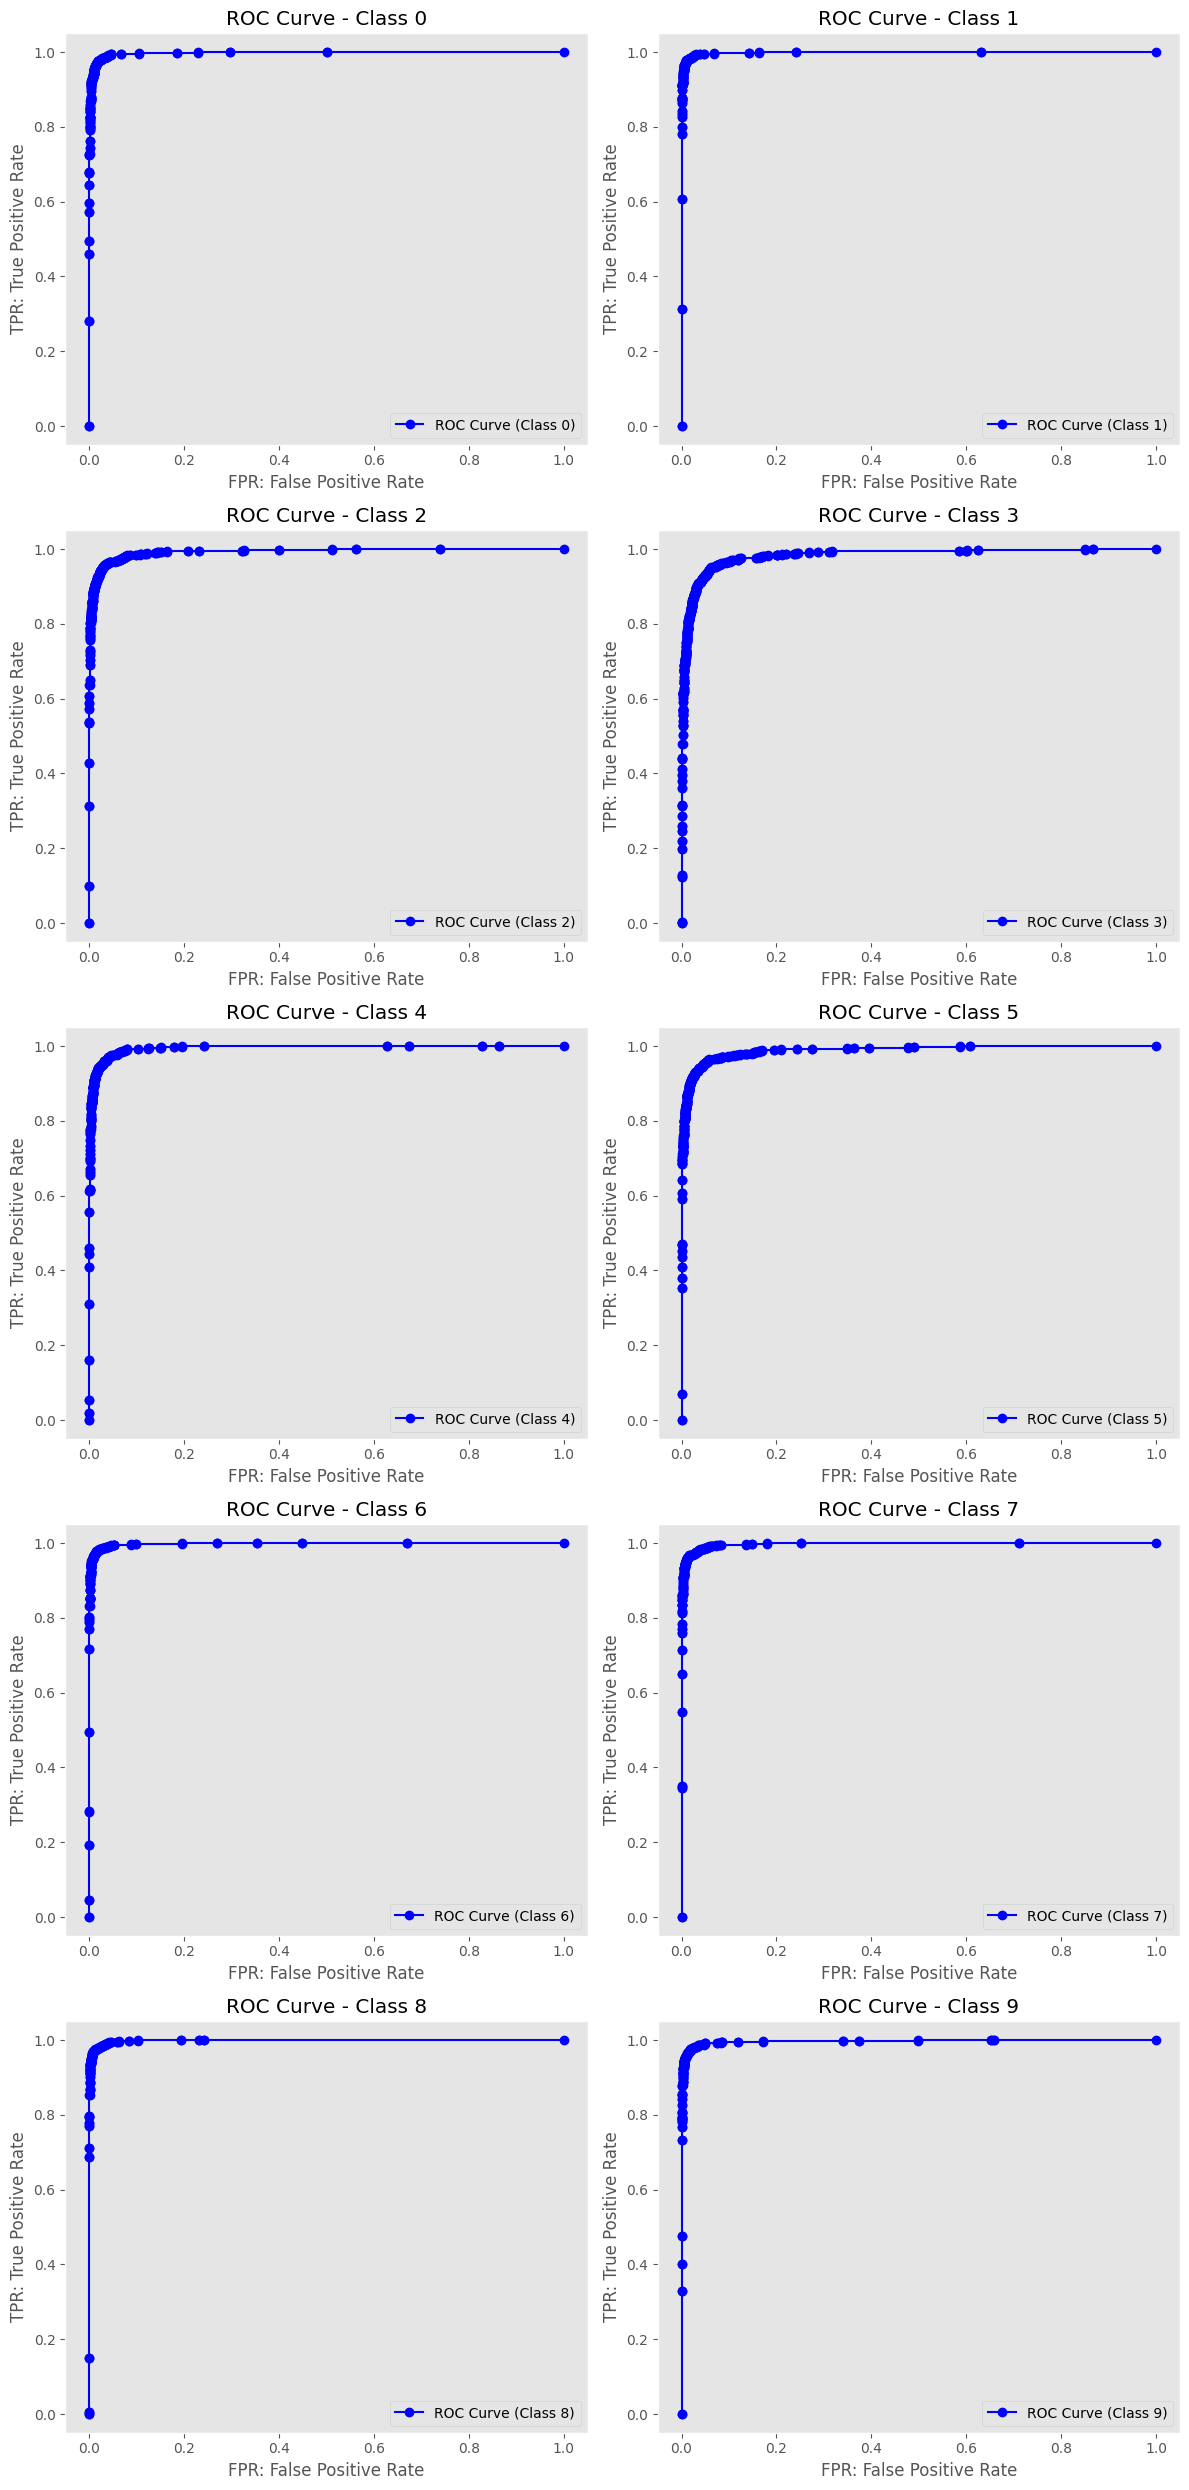

In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# y_val_true はラベル（0～9）を含むリスト
y_val_true = torch.tensor(y_val_true)

# クラスごとの確率を保存するリスト
probs = []

# モデルを推論モードにする
model.eval()

# メモリ節約のため、勾配計算を無効にする
with torch.no_grad():
    for val_imgs, _ in validation_dataloader:
        val_imgs = val_imgs.to(device)  # GPUへ転送
        output = model(val_imgs)  # モデルの出力
        prob_batch = torch.softmax(output, dim=1)  # 各クラスの確率を取得
        probs.append(prob_batch.cpu())  # CPUに戻してリストに保存

        # メモリ解放
        del val_imgs, output, prob_batch
        torch.cuda.empty_cache()

# すべての確率値を連結
prob = torch.cat(probs).numpy()

# ROC曲線の描画
fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

for n in range(10):
    # クラス n の確率を取得
    prob_n = prob[:, n]  # `prob` は shape (サンプル数, クラス数) のはず

    # 0/1 ラベルの取得
    one_zero_labels = (y_val_true == n).cpu().numpy()

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(one_zero_labels, prob_n)

    # AUC算出
    auc_score = roc_auc_score(one_zero_labels, prob_n)
    print(f"Class {n} - ROC AUC Score: {auc_score:.4f}")

    # 行インデックスと列インデックスの計算
    row_idx = n // 2  # 行インデックス
    col_idx = n % 2   # 列インデックス

    # グラフ描画
    axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label=f"ROC Curve (Class {n})")
    axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
    axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
    axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
    axes[row_idx, col_idx].legend()
    axes[row_idx, col_idx].grid()

plt.tight_layout()
plt.show()
